In [1]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [2]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()
       
        m2      = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm2, ym2  = m2(LON, LAT)
        im2     = m2.plot(xm2,ym2,'.', color='k',linewidth=2.)

        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

In [3]:
def investigate_traj(figsize, proj, nb_traj, hfacc_level):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.basemap import Basemap
    import cmocean
    
    fig     = plt.figure(figsize=figsize)
    
    if proj=='ortho':
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0, resolution="l")
    elif proj=='merc':
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-40.,llcrnrlon=120.,urcrnrlon=270.,lat_ts=-60.,resolution='c')
    elif proj=='lamb':
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
    

    
    # Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
    xm, ym  = m(Xf, Yf)
    im      = m.contourf(xm, ym, hFacC[hfacc_level,...], extend='both', cmap='Greys_r')
    
    # Plot the salinity
    xm, ym  = m(XC, YC)
    im      = m.contourf(xm, ym, mean_Salt_30, levels=np.linspace(32.8,35.3,50), extend='both', cmap=cmocean.cm.haline)
    cbar    = m.colorbar(im,pad='10%')
    cbar.set_label('Salinity', fontsize =16)
        
    # Plot all the traj
    for p in nb_traj: 
        xm, ym  = m(LON[:,p], LAT[:,p])
        im      = m.plot(xm, ym, '-', color='orange',linewidth=0.4)
        xm, ym  = m(LON[0,p], LAT[0,p])
        im      = m.plot(xm, ym, '.', color='yellow',linewidth=2.)
        xm, ym  = m(LON[-1,p], LAT[-1,p])
        im      = m.plot(xm, ym, '*', color='r',linewidth=3.)
        
    m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
    #plt.title('10 000 parti, 5 years (hFacC and S at 30 m)', fontsize=18)
    #plt.savefig(path_save + title_save, bbox_inches='tight')

In [4]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle
import cmocean

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

In [5]:
# Mercator salinity
mean_Salt_surf = pickle_load('mean_Salt_surf_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_30     = pickle_load('mean_Salt_30_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_100   = pickle_load('mean_Salt_100_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_200   = pickle_load('mean_Salt_200_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_500   = pickle_load('mean_Salt_500_2', '/data/ebent/Bigger_domain/', verbose=False)

# Mercator temperature
mean_Theta_surf = pickle_load('mean_Theta_surf_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_30     = pickle_load('mean_Theta_30_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_100   = pickle_load('mean_Theta_100_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_200   = pickle_load('mean_Theta_200_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_500   = pickle_load('mean_Theta_500_2', '/data/ebent/Bigger_domain', verbose=False)

In [6]:
# Load files
file1 = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

In [7]:
# Mercator grid for salinity
lon_min = 1800
lon_max = 3240
lat_min = 0
lat_max = 1170

lat     = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -30,12
lon     = file1.variables['lon'][lon_min:lon_max] # de 150,04 a 269,95
Lon, Lat = np.meshgrid(lon,lat)

In [8]:
# This is hFacC for the SOUTHERN HEMISPHERE

file_h = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file_h.get('hFacC')
hFacC = np.array(hFacC)
Xf = file_h.get('XC')
Xf = np.array(Xf)
Yf = file_h.get('YC')
Yf = np.array(Yf)

In [9]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"
lon_min   = 1440 
lon_max   = 3241
lat_min   = 0 
lat_max   = 1024

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04
XC, YC    = np.meshgrid(XC, YC)

hfacc = hFacC[:, lat_min:lat_max, lon_min:lon_max]

In [10]:
southern_front = pickle_load('ACC_southern_front', '/data/ebent/', verbose=False)
southern_front = np.ma.masked_array(southern_front, mask=False)

***

In [ ]:
path = '/data/ebent/Octopus/output/12_10_4mld/'

DEP = pickle_load('DEP_12_10_4', path, verbose=False)
LAT = pickle_load('LAT_12_10_4', path, verbose=False)
LON = pickle_load('LON_12_10_4', path, verbose=False)

z = pickle_load('z_12_10_4', path, verbose=False)
y = pickle_load('y_12_10_4', path, verbose=False)
x = pickle_load('x_12_10_4', path, verbose=False)

# Plots

## Experiment 12_10000parti and 12_10_4mld

In [11]:
run Octopus/Octopus-master/scripts/p_xy.py

data has 166 records
glued data : 12_10_4MLD_0006.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/12_10_4mld/


/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [37]:
LON = lon
LAT = lat

With no MLD

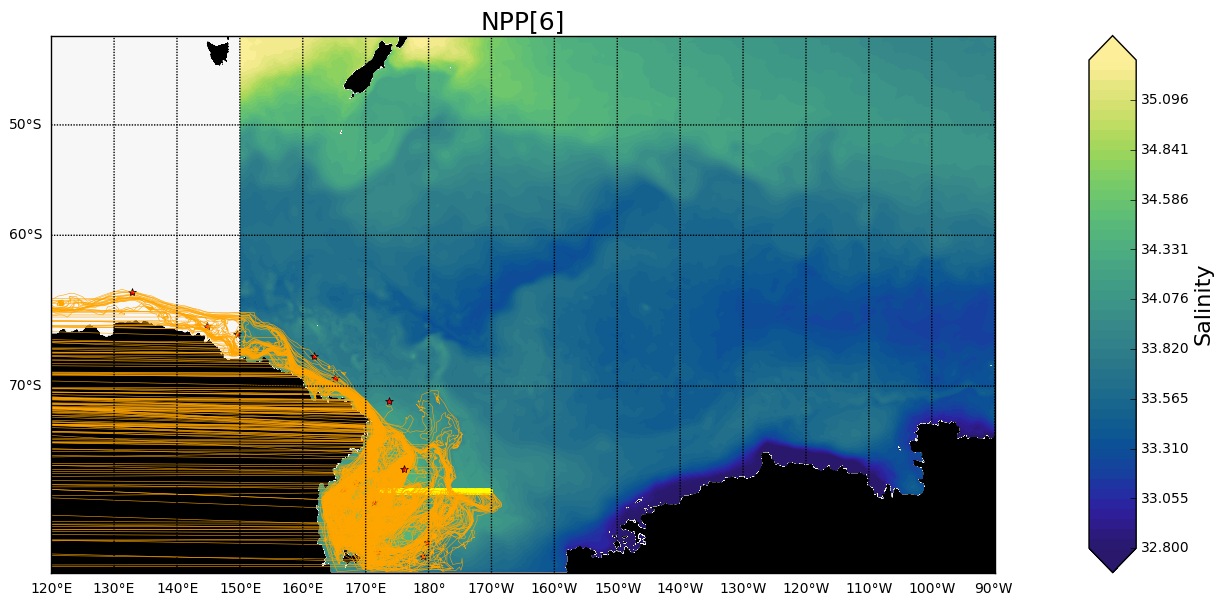

In [49]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(200), hfacc_level=9)
plt.title('NPP[6]', fontsize=18)

With MLD

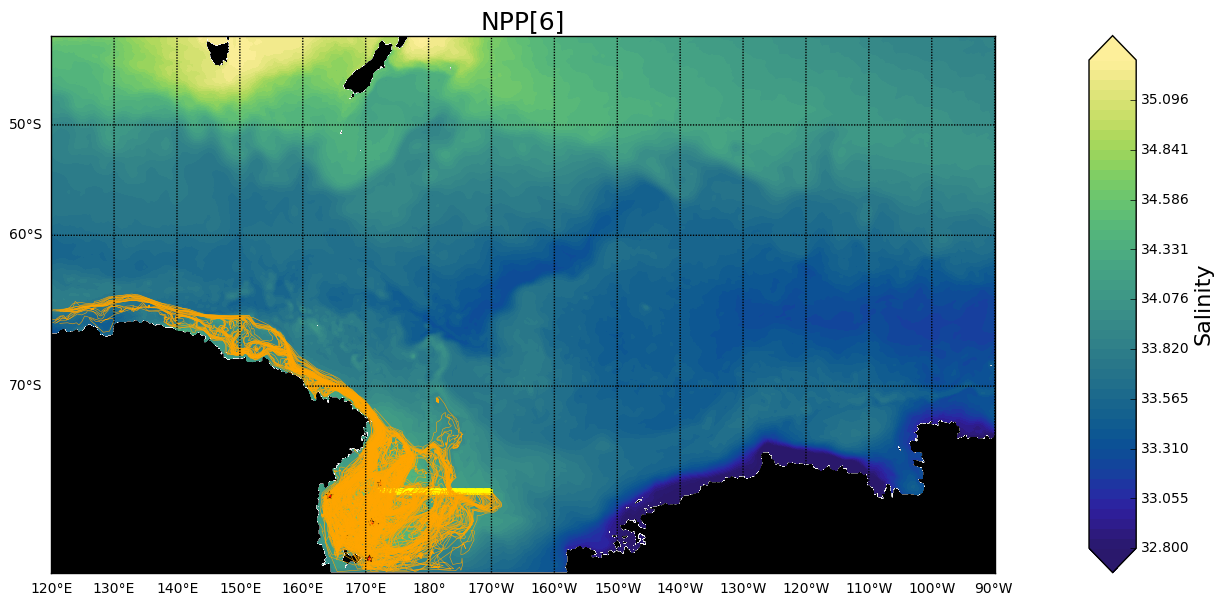

In [172]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(200), hfacc_level=9)
plt.title('NPP[6]', fontsize=18)

With no MLD

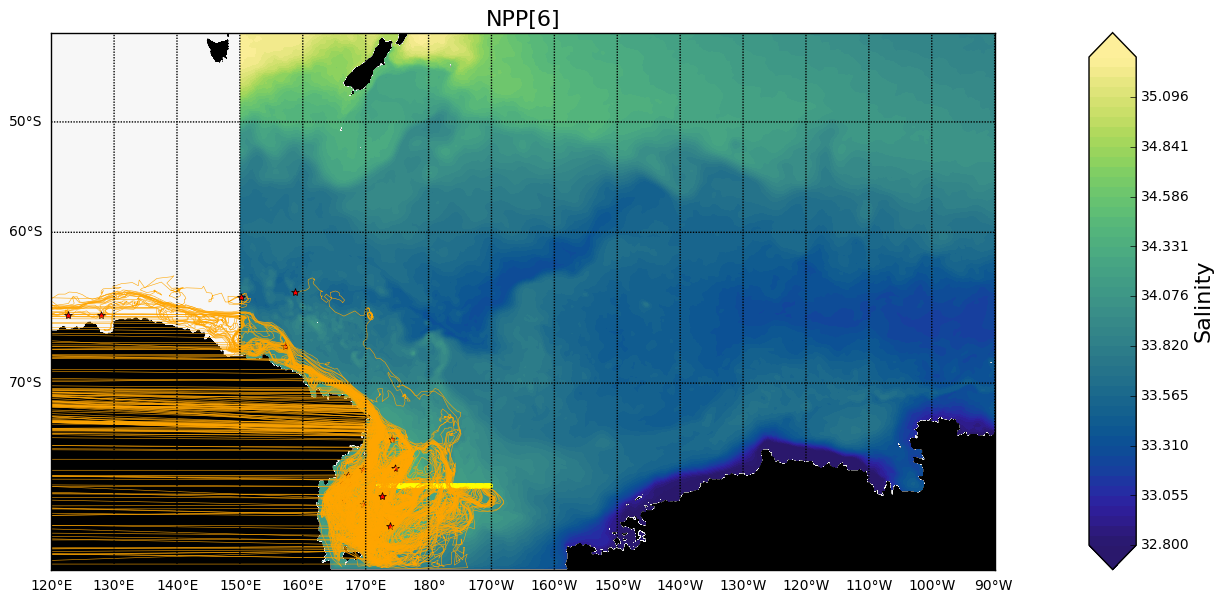

In [50]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(200,400), hfacc_level=9)
plt.title('NPP[6]', fontsize=16)

With MLD

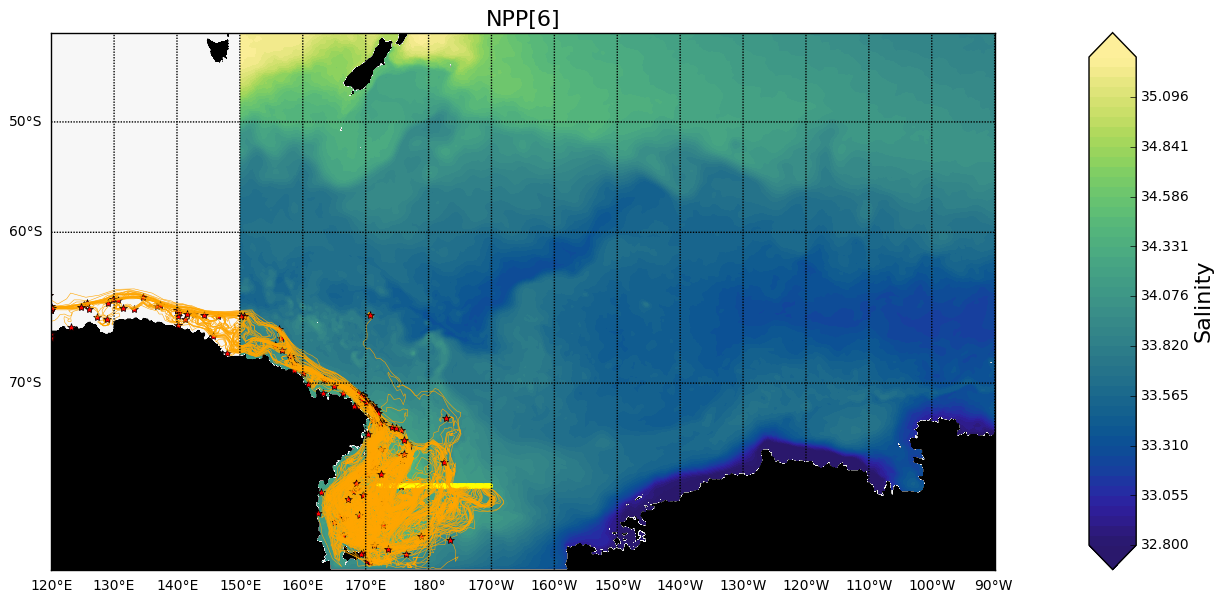

In [15]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(200,400), hfacc_level=9)
plt.title('NPP[6]', fontsize=16)

With MLD

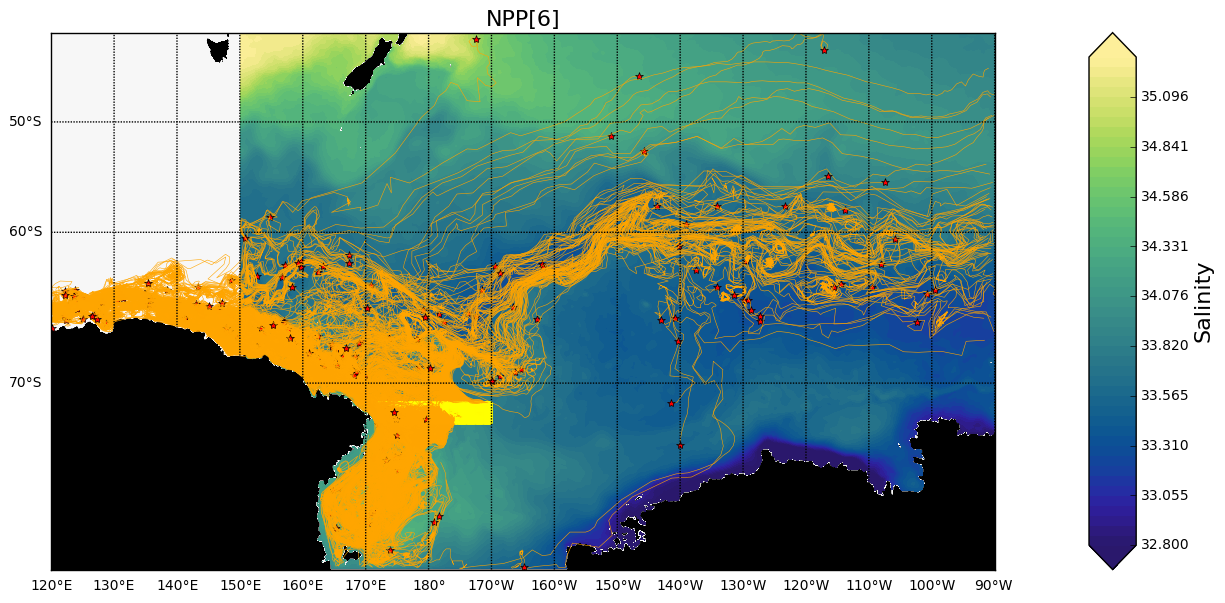

In [32]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(6000,8000), hfacc_level=9)
plt.title('NPP[6]', fontsize=16)

With MLD

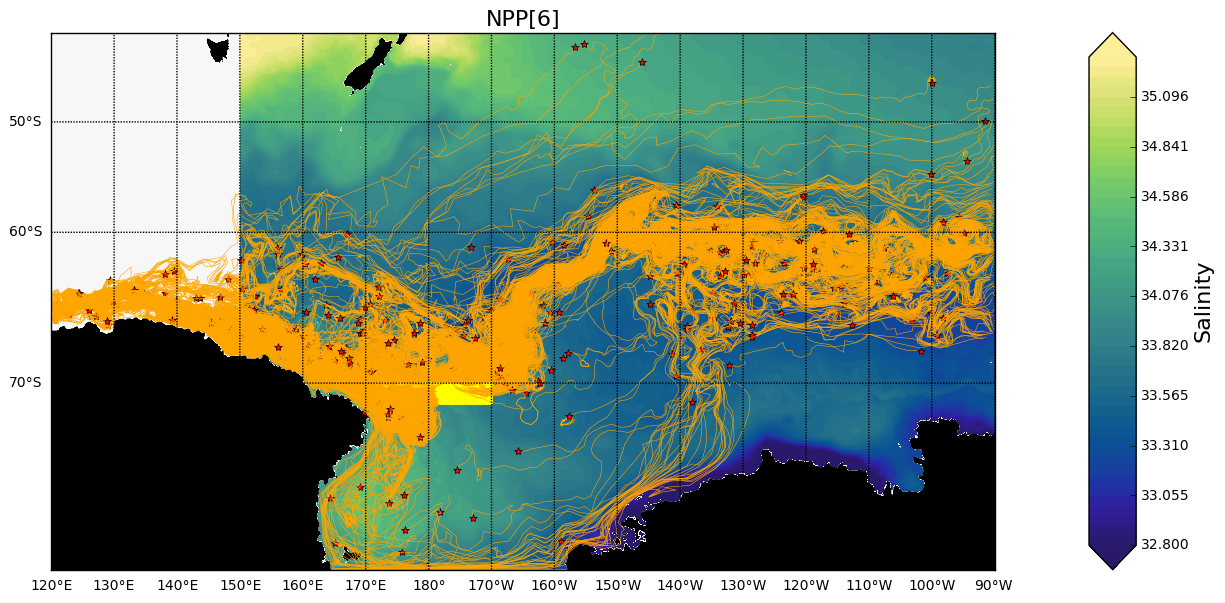

In [31]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(8000,10000), hfacc_level=9)
plt.title('NPP[6]', fontsize=16)

With MLD

/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


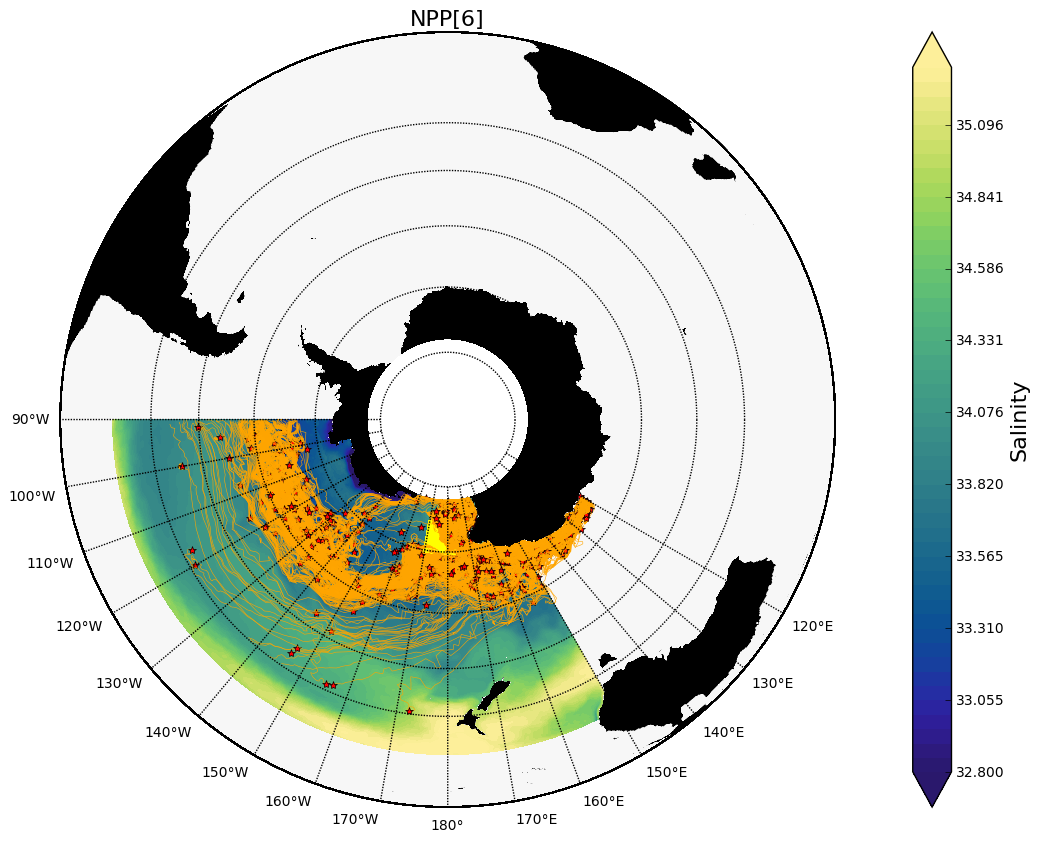

In [28]:
investigate_traj(figsize=(14,10), proj='ortho', nb_traj=range(800,10000), hfacc_level=9)
plt.title('NPP[6]', fontsize=16)

***

# Mettre un mask sur les traj

Il a fallut mettre hFacC sur la même taille que mercator, on l'appelle hfacc

In [393]:
run /home/ebent/Octopus/Octopus-master/scripts/p_xy.py

data has 166 records
glued data : 12_10_4MLD_0006.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/12_10_4mld/


In [394]:
LON = lon
LAT = lat
DEP = dep

Ce run me donne : lon, lat, dep (pos en degrés) et xround, yround, zround (pos en indices dans le domaine du model que j'appelle "bigger domain")

In [395]:
LON = np.ma.masked_array(lon, mask=False)
LAT = np.ma.masked_array(lat, mask=False)
DEP = np.ma.masked_array(dep, mask=False)

x = np.ma.masked_array(xround, mask=False)
y = np.ma.masked_array(yround, mask=False)
z = np.ma.masked_array(zround, mask=False)

Mettre un mask sur LAT puis LON que l'on reproduira sur les autres variables

In [18]:
# Mask les parti qui sortent du domaine en latitude (sud et nord)

LAT = np.ma.masked_where(LAT < YC[0], LAT) # de -77,99 a -40,05
LAT = np.ma.masked_where(LAT > YC[-1], LAT)

print(YC[0], YC[-1])

(-77.9913330078125, -40.055816650390625)


In [19]:
LON.mask = LAT.mask

In [20]:
# Mask les parti qui sortent du domaine en longitude (est et ouest)

LON = np.ma.masked_where(LON < XC[0], LON) # de 120,04 a 270,04
LON = np.ma.masked_where(LON > XC[-1], LON)

print(XC[0], XC[-1])

(120.04166412353516, 270.04165649414062)


# Only do this now that I changed p_xy.py

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti

In [396]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué

for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            LON.mask[t:,p]=True
            break
            #print t, p

### Here I put a mask on hfacc==0

In [397]:
for p in range(z.shape[1]):
    for t in range(z.shape[0]):
        if LON.mask[t,p]==True: # changed z ton LON here, should work next time I run it
            continue
        if hfacc[z[t,p], y[t,p], x[t,p]]==0.:
            #print t,p
            LON.mask[t:,p]=True

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti AGAIN

In [398]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué

for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            LON.mask[t:,p]=True
            break

On applique le mask de LON pour les autres variables

In [14]:
LAT = np.ma.masked_array(lat, mask=False)
DEP = np.ma.masked_array(dep, mask=False)

In [399]:
# Make sure all pos have the same mask
LAT.mask = LON.mask
DEP.mask = LON.mask

x.mask = LON.mask
y.mask = LON.mask
z.mask = LON.mask

xround.mask = LON.mask
yround.mask = LON.mask
zround.mask = LON.mask

***

In [35]:
path = '/data/ebent/Octopus/output/12_10_4mld/'

pickle_save('DEP_12_10_4', path, DEP)
pickle_save('LAT_12_10_4', path, LAT)
pickle_save('LON_12_10_4', path, LON)

pickle_save('z_12_10_4', path, z)
pickle_save('y_12_10_4', path, y)
pickle_save('x_12_10_4', path, x)

('saved at : ', '/data/ebent/Octopus/output/12_10_4mld/DEP_12_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/12_10_4mld/LAT_12_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/12_10_4mld/LON_12_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/12_10_4mld/z_12_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/12_10_4mld/y_12_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/12_10_4mld/x_12_10_4.npy')


***

In [229]:
# Create a meshgrid to plot in index coordinates
xc = np.arange(1801)
yc = np.arange(1024)
xc, yc = np.meshgrid(xc,yc)

# Have to work on number of parti that are false in z

In [321]:
zone1 = 0
zone2 = 0
zone3 = 0
zone4 = 0
zone5 = 0
error = 0


for p in range(npts): #x.shape[1]):
    
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = yround[:,p].mask # mask elements of south_front that are irrelevant
    
    # This finds if the pos of the parti reaches outside of the ACC front where southern_front == 0
    north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
    
    # This finds if the pos of the parti goes past XC = 150
    east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=360))) # XC[360] = 150,04
    
    # This finds if the pos of the parti goes past XC = 250
    west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=1560))) # XC[1560] = 250,04
    
    #print p
    #print 'north :',north_outside_RG.size,', east :',east_outside_RG.size,', west :',west_outside_RG.size
     
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size==0.:
        #print 'particle in Ross Gyre'
        zone1+=1
        
    if north_outside_RG.size>0.:
    #    print 'particle outside of Ross Gyre to the North'
        zone2+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size==0.:
        #print 'particle outside of Ross Gyre to the East'
        zone3+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the West'
        zone4+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the East then West'
        zone5+=1  
    
print ''     
print 'Particles that stay in the Ross Gyre :', zone1
print 'Particles that go North :', zone2
print 'Particles that go East :', zone3
print 'Particles that go West :', zone4
print 'Particles that go East then West :', zone5
print 'Total number of particles :', zone1+zone2+zone3+zone4+zone5


Particles that stay in the Ross Gyre : 4722
Particles that go North : 252
Particles that go East : 5018
Particles that go West : 6
Particles that go East then West : 2
Total number of particles : 10000


### Same but in percentages

In [320]:
print 'Particles that stay in the Ross Gyre :', zone1*100./npts, '%'
print 'Particles that go North :', zone2*100./npts, '%'
print 'Particles that go East :', zone3*100./npts, '%'
print 'Particles that go West :', zone4*100./npts, '%'
print 'Particles that go East then West :', zone5*100./npts, '%'
print 'Total number of particles :', zone1+zone2+zone3+zone4+zone5

Particles that stay in the Ross Gyre : 47.22 %
Particles that go North : 2.52 %
Particles that go East : 50.18 %
Particles that go West : 0.06 %
Particles that go East then West : 0.02 %
Total number of particles : 10000


## Look at parti that go E and N

In [415]:
zone1 = 0
zone2 = 0
zone3 = 0
zone4 = 0
zone3 = 0
error = 0
humhum = []

for p in range(8000, 10000): #x.shape[1]):
    #print p
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one parti traj
    south_front.mask = yround[:,p].mask # mask elements of south_front that are irrelevant
    
    # this finds if the pos of the parti reaches outside of the ACC front where southern_front == 0
    north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
    
    
    east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=360))) 
    west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=1560)))
    #print('north', north_outside_RG.size,'east',  east_outside_RG.size,'west', west_outside_RG.size)
    #inside_RG = 
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size==0.:
        #print 'particle in Ross Gyre'
        zone1+=1
        
    if north_outside_RG.size>0.:
    #    print 'particle outside of Ross Gyre to the North'
        zone2+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size==0.:
        #print 'particle outside of Ross Gyre to the East'
        zone3+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the West'
        zone4+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the East then West'
        zone5+=1  
        
    if north_outside_RG.size>0. and east_outside_RG.size>0.:
        humhum.append(p)
        print p
        print 'north :',north_outside_RG.size,', east :',east_outside_RG.size,', west :',west_outside_RG.size
        print 'LOOK : particle is North and East !'
        
    
        
print ''     
print 'Particles that stay in the Ross Gyre :', zone1
print 'Particles that go North :', zone2
print 'Particles that go East :', zone3
print 'Particles that go West :', zone4
print 'Particles that go East then West :', zone5
print 'Total number of particles :', zone1+zone2+zone3+zone4+zone5

8110
north : 41 , east : 36 , west : 14
LOOK : particle is North and East !
8328
north : 7 , east : 52 , west : 0
LOOK : particle is North and East !
8348
north : 6 , east : 23 , west : 0
LOOK : particle is North and East !
8514
north : 1 , east : 35 , west : 0
LOOK : particle is North and East !
8533
north : 63 , east : 35 , west : 11
LOOK : particle is North and East !
8606
north : 54 , east : 43 , west : 13
LOOK : particle is North and East !
8668
north : 59 , east : 8 , west : 17
LOOK : particle is North and East !
8933
north : 41 , east : 43 , west : 0
LOOK : particle is North and East !
8971
north : 1 , east : 68 , west : 0
LOOK : particle is North and East !
9012
north : 1 , east : 44 , west : 0
LOOK : particle is North and East !
9211
north : 32 , east : 38 , west : 0
LOOK : particle is North and East !
9606
north : 27 , east : 71 , west : 0
LOOK : particle is North and East !
9766
north : 5 , east : 17 , west : 0
LOOK : particle is North and East !

Particles that stay in the 

In [322]:
zone1 = 0
zone2 = 0
zone3 = 0
zone4 = 0
zone3 = 0
error = 0
humhum = []

for p in range(8000, 10000): #x.shape[1]):
    #print p
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one parti traj
    south_front.mask = yround[:,p].mask # mask elements of south_front that are irrelevant
    
    # this finds if the pos of the parti reaches outside of the ACC front where southern_front == 0
    north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
    
    
    east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=360))) 
    west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=1560)))
    #print('north', north_outside_RG.size,'east',  east_outside_RG.size,'west', west_outside_RG.size)
    #inside_RG = 
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size==0.:
        #print 'particle in Ross Gyre'
        zone1+=1
        
    if north_outside_RG.size>0.:
    #    print 'particle outside of Ross Gyre to the North'
        zone2+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size==0.:
        #print 'particle outside of Ross Gyre to the East'
        zone3+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the West'
        zone4+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the East then West'
        zone5+=1  
        
    if north_outside_RG.size>0. and east_outside_RG.size>0.:
        humhum.append(p)
        print p
        print 'north :',north_outside_RG.size,', east :',east_outside_RG.size,', west :',west_outside_RG.size
        print 'LOOK : particle is North and East !'
        
    
        
print ''     
print 'Particles that stay in the Ross Gyre :', zone1
print 'Particles that go North :', zone2
print 'Particles that go East :', zone3
print 'Particles that go West :', zone4
print 'Particles that go East then West :', zone5
print 'Total number of particles :', zone1+zone2+zone3+zone4+zone5

8175
north : 54 , east : 52 , west : 3
LOOK : particle is North and East !
8301
north : 1 , east : 38 , west : 0
LOOK : particle is North and East !
8367
north : 1 , east : 40 , west : 0
LOOK : particle is North and East !
8477
north : 56 , east : 39 , west : 13
LOOK : particle is North and East !
8571
north : 2 , east : 39 , west : 0
LOOK : particle is North and East !
8764
north : 1 , east : 53 , west : 0
LOOK : particle is North and East !
8960
north : 3 , east : 45 , west : 0
LOOK : particle is North and East !
9112
north : 1 , east : 52 , west : 0
LOOK : particle is North and East !
9332
north : 16 , east : 33 , west : 0
LOOK : particle is North and East !
9338
north : 19 , east : 63 , west : 0
LOOK : particle is North and East !
9500
north : 16 , east : 55 , west : 0
LOOK : particle is North and East !

Particles that stay in the Ross Gyre : 357
Particles that go North : 191
Particles that go East : 1446
Particles that go West : 5
Particles that go East then West : 3
Total number

In [416]:
humhum

[8110, 8328, 8348, 8514, 8533, 8606, 8668, 8933, 8971, 9012, 9211, 9606, 9766]

In [323]:
humhum

[8175, 8301, 8367, 8477, 8571, 8764, 8960, 9112, 9332, 9338, 9500]

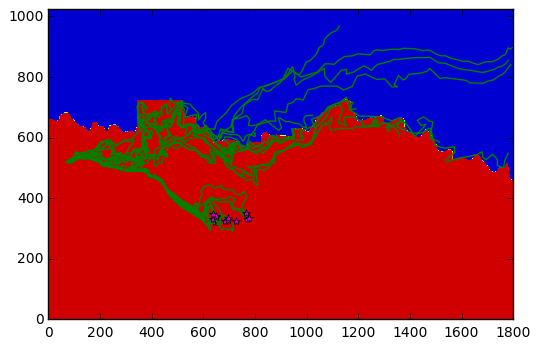

In [417]:
for p in humhum:
    plt.contourf(xc, yc, southern_front)
    plt.plot(xround[:,p],yround[:,p], '-g')
    plt.plot(xround[0,p],yround[0,p], '*m')
    #plt.plot(xround[77:,p],yround[77:,p], '.k')

In [ ]:
for p in humhum:
    plt.contourf(xc, yc, southern_front)
    plt.plot(xround[:,p],yround[:,p], '-g')
    plt.plot(xround[0,p],yround[0,p], '*m')
    #plt.plot(xround[77:,p],yround[77:,p], '.k')

## Test some specific particles

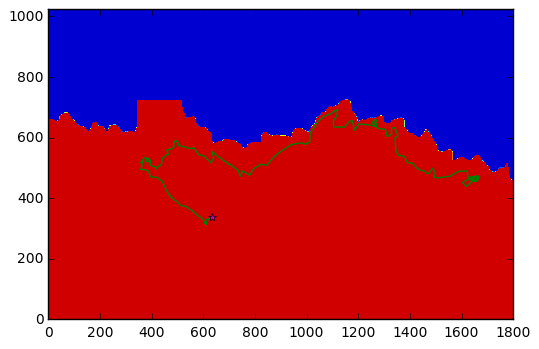

In [236]:
p = 9104
plt.contourf(xc, yc, southern_front)
plt.plot(xround[:,p],yround[:,p], '-g')
plt.plot(xround[0,p],yround[0,p], '*m')
#plt.plot(xround[77:,p],yround[77:,p], '.k')

# Try to count but with the dimension of time

In [213]:
run /home/ebent/Octopus/Octopus-master/scripts/p_xy.py

data has 181 records
glued data : 12_10_4MLD_0001.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/12_10_4mld/


### Here I put a mask on hfacc==0

In [214]:
for p in range(xround.shape[1]):
    for t in range(xround.shape[0]):
        if xround.mask[t,p]==True: # changed LON to xround here, should work next time I run it
            continue
        if hfacc[z[t,p], y[t,p], x[t,p]]==0.:
            #print t,p
            xround.mask[t:,p]=True

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Here I mask all time steps after the first LON.mask[t,p]==True for each parti AGAIN

In [215]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué

for p in range(xround.shape[1]):
    for t in range(xround.shape[0]):
        if xround.mask[t,p]==True:
            xround.mask[t:,p]=True
            break

On applique le mask de LON pour les autres variables

In [216]:
# Make sure all pos have the same mask
yround.mask = xround.mask
zround.mask = xround.mask

In [245]:
npts = 10000

***

# Count the particles in each zone

This counts how many particles finish/stay in each zone

In [246]:
zone1 = 0
zone2 = 0
zone3 = 0
zone4 = 0
zone5 = 0
error = 0

for p in range(npts): #xround.shape[0]):
    a = zone1
    b = zone2
    c = zone3
    d = zone4
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    
    # This finds if the pos of the parti reaches outside of the ACC front where southern_front == 0
    north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
    
    # This finds if the pos of the parti goes past XC = 150
    east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=360))) # XC[360] = 150,04
    
    # This finds if the pos of the parti goes past XC = 250
    west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=1560))) # XC[1560] = 250,04
    
    #print p
    #print 'north :',north_outside_RG.size,', east :',east_outside_RG.size,', west :',west_outside_RG.size
     
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size==0.:
        #print 'particle in Ross Gyre'
        zone1+=1
        
    if north_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the North'
        zone2+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size==0.:
        #print 'particle outside of Ross Gyre to the East'
        zone3+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the West'
        zone4+=1
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the East then West'
        zone5+=1  
    
    ########## Total number of particles was 10 002 so I looked for the reason and found that some parti go E and W
    #X = (zone1-a)+(zone2-b)+(zone3-c)+(zone4-d)
    #if X>1:
    #    print p
    
        
print ''     
print 'Particles that stay in the Ross Gyre :', zone1
print 'Particles that go North :', zone2
print 'Particles that go East :', zone3
print 'Particles that go West :', zone4
print 'Particles that go East then West :', zone5
print 'Total number of particles :', zone1+zone2+zone3+zone4+zone5


Particles that stay in the Ross Gyre : 4722
Particles that go North : 252
Particles that go East : 5018
Particles that go West : 6
Particles that go East then West : 2
Total number of particles : 10000


# Search for the indexes of the particles in each zone

This selects the index p of the particles that finish/stay in each zone

In [283]:
parti_of_zone1 = []
parti_of_zone2 = []
parti_of_zone3 = []
parti_of_zone4 = []
parti_of_zone5 = []

for p in range(npts):    
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    
    # This finds if the pos of the parti reaches outside of the ACC front where southern_front == 0
    north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
    
    # This finds if the pos of the parti goes past XC = 150
    east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=360))) # XC[360] = 150,04
    
    # This finds if the pos of the parti goes past XC = 250
    west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=1560))) # XC[1560] = 250,04
    
    #print p
    #print 'north :',north_outside_RG.size,', east :',east_outside_RG.size,', west :',west_outside_RG.size
       
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size==0.:
    #print 'particle in Ross Gyre'
       parti_of_zone1.append(p)
        
    if north_outside_RG.size>0.:
    #    print 'particle outside of Ross Gyre to the North'
        parti_of_zone2.append(p)
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size==0.:
        #print 'particle outside of Ross Gyre to the East'
        parti_of_zone3.append(p)
        
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size>0.:
        #print 'particle outside of Ross Gyre to the West'
        parti_of_zone4.append(p)
    
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size>0.:
        parti_of_zone5.append(p)

        
print ''     
print 'Particles that stay in the Ross Gyre :', len(parti_of_zone1)
print 'Particles that go North :', len(parti_of_zone2)
print 'Particles that go East :', len(parti_of_zone3)
print 'Particles that go West :', len(parti_of_zone4)
print 'Particles that go East then West :', len(parti_of_zone5)
print 'Total number of particles :', len(parti_of_zone1)+len(parti_of_zone2)+len(parti_of_zone3)+len(parti_of_zone4)+len(parti_of_zone5)


Particles that stay in the Ross Gyre : 4722
Particles that go North : 252
Particles that go East : 5018
Particles that go West : 6
Particles that go East then West : 2
Total number of particles : 10000


## For each zone, calculate at each time step how many particles are in the zone

In [284]:
evo_zone1 = np.zeros(xround.shape[0])
evo_zone1[0] = 0
for p in parti_of_zone1:
    #print p
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    
    for t in range(xround.shape[0]):
        #print xround[t,p]
        if south_front[t]!=0 and xround[t,p]>360 and xround[t,p]<1560:
            #print t, p
            evo_zone1[t]=evo_zone1[t]+1
        else:
            evo_zone1[t]=evo_zone1[t]

In [285]:
# Particles that go North
evo_zone2 = np.zeros(xround.shape[0])

for p in parti_of_zone2:
    #print p
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    
    for t in range(xround.shape[0]):
        #print xround[t,p]
        if south_front[t]==0:
            #print t, p
            evo_zone2[t]=evo_zone2[t]+1
        else:
            evo_zone2[t]=evo_zone2[t]

In [286]:
# Particles that go East
evo_zone3 = np.zeros(xround.shape[0])

for p in parti_of_zone3:
    #print p
    for t in range(xround.shape[0]):
        
        #print xround[t,p]
        if xround[t,p]<=360:
            #print t, p
            evo_zone3[t]=evo_zone3[t]+1
        else:
            evo_zone3[t]=evo_zone3[t]

In [287]:
# Particles that go West
evo_zone4 = np.zeros(xround.shape[0])

for p in parti_of_zone2:
    #print p
    for t in range(xround.shape[0]):
        
        #print xround[t,p]
        if xround[t,p]>=1560:
            #print t, p
            evo_zone4[t]=evo_zone4[t]+1
        else:
            evo_zone4[t]=evo_zone4[t]

In [288]:
# Particles that go East then West
evo_zone5 = np.zeros(xround.shape[0])

for p in parti_of_zone5:
    #print p
    for t in range(xround.shape[0]):
        
        #print xround[t,p]
        if xround[t,p]<=1560 and xround[t,p]>=1560:
            #print t, p
            evo_zone5[t]=evo_zone5[t]+1
        else:
            evo_zone5[t]=evo_zone5[t]

In [289]:
total = np.ones(xround.shape[0])*10000

In [290]:
total = total-evo_zone2-evo_zone3-evo_zone4-evo_zone5

In [316]:
total[0]

10000.0

### Plot according to time


Particles that stay in the Ross Gyre : 47.22 %
Particles that go North : 2.52 %
Particles that go East : 50.18 %
Particles that go West : 0.06 %
Particles that go East then West : 0.02 %
Total number of particles : 10000


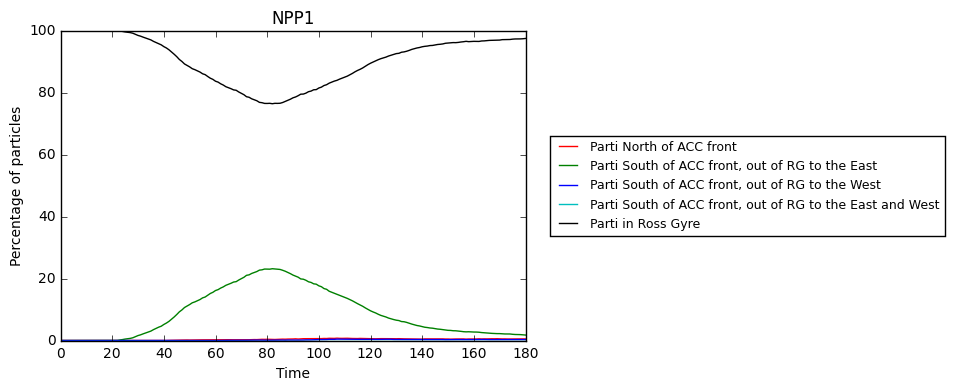

In [315]:
plt.figure()

#plt.plot(evo_zone1*100/npts, '-m')
plt.plot(evo_zone2*100/npts, '-r', label='Parti North of ACC front')
plt.plot(evo_zone3*100/npts, '-g', label='Parti South of ACC front, out of RG to the East')
plt.plot(evo_zone4*100/npts, '-b', label='Parti South of ACC front, out of RG to the West')
plt.plot(evo_zone5*100/npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
plt.plot(total*100/npts, '-k', label='Parti in Ross Gyre')

plt.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
plt.xlabel('Time')
plt.ylabel('Percentage of particles')
plt.title('NPP1')

print ''
print 'Particles that stay in the Ross Gyre :', len(parti_of_zone1)*100./npts, '%'
print 'Particles that go North :', len(parti_of_zone2)*100./npts, '%'
print 'Particles that go East :', len(parti_of_zone3)*100./npts, '%'
print 'Particles that go West :', len(parti_of_zone4)*100./npts, '%'
print 'Particles that go East then West :', len(parti_of_zone5)*100./npts, '%'
print 'Total number of particles :', len(parti_of_zone1)+len(parti_of_zone2)+len(parti_of_zone3)+len(parti_of_zone4)+len(parti_of_zone5)

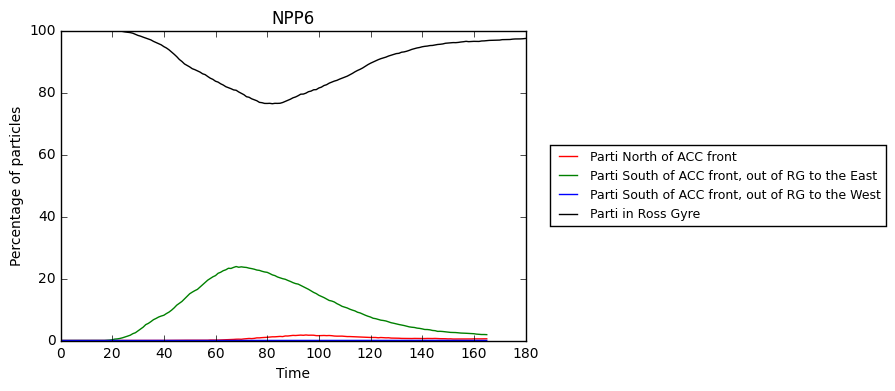

In [282]:
plt.figure()

#plt.plot(evo_zone1*100/npts, '-m')
plt.plot(evo_zone2*100/npts, '-r', label='Parti North of ACC front')
plt.plot(evo_zone3*100/npts, '-g', label='Parti South of ACC front, out of RG to the East')
plt.plot(evo_zone4*100/npts, '-b', label='Parti South of ACC front, out of RG to the West')
plt.plot(evo_zone5*100/npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
plt.plot(total*100/npts, '-k', label='Parti in Ross Gyre')

plt.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
plt.xlabel('Time')
plt.ylabel('Percentage of particles')
plt.title('NPP6')

print ''
print 'Particles that stay in the Ross Gyre :', len(parti_of_zone1)*100./npts, '%'
print 'Particles that go North :', len(parti_of_zone2)*100./npts, '%'
print 'Particles that go East :', len(parti_of_zone3)*100./npts, '%'
print 'Particles that go West :', len(parti_of_zone4)*100./npts, '%'
print 'Particles that go East then West :', len(parti_of_zone5)*100./npts, '%'
print 'Total number of particles :', len(parti_of_zone1)+len(parti_of_zone2)+len(parti_of_zone3)+len(parti_of_zone4)+len(parti_of_zone5)

## Save

In [291]:
NPP = 'NPP1'
pickle_save(NPP + '_evo_zone1', '/data/ebent/Particle_analysis/', evo_zone1)
pickle_save(NPP + '_evo_zone2', '/data/ebent/Particle_analysis/', evo_zone2)
pickle_save(NPP + '_evo_zone3', '/data/ebent/Particle_analysis/', evo_zone3)
pickle_save(NPP + '_evo_zone4', '/data/ebent/Particle_analysis/', evo_zone4)
pickle_save(NPP + '_evo_zone5', '/data/ebent/Particle_analysis/', evo_zone5)

('saved at : ', '/data/ebent/Particle_analysis/NPP1_evo_zone1.npy')
('saved at : ', '/data/ebent/Particle_analysis/NPP1_evo_zone2.npy')
('saved at : ', '/data/ebent/Particle_analysis/NPP1_evo_zone3.npy')
('saved at : ', '/data/ebent/Particle_analysis/NPP1_evo_zone4.npy')
('saved at : ', '/data/ebent/Particle_analysis/NPP1_evo_zone5.npy')


## Load

In [279]:
NPP = 'NPP6'
evo_zone1 = pickle_load(NPP + '_evo_zone1', '/data/ebent/Particle_analysis/')
evo_zone2 = pickle_load(NPP + '_evo_zone2', '/data/ebent/Particle_analysis/')
evo_zone3 = pickle_load(NPP + '_evo_zone3', '/data/ebent/Particle_analysis/')
evo_zone4 = pickle_load(NPP + '_evo_zone4', '/data/ebent/Particle_analysis/')
evo_zone5 = pickle_load(NPP + '_evo_zone5', '/data/ebent/Particle_analysis/')

('loaded from : ', '/data/ebent/Particle_analysis/evo_zone1_NPP6.npy')
('loaded from : ', '/data/ebent/Particle_analysis/evo_zone2_NPP6.npy')
('loaded from : ', '/data/ebent/Particle_analysis/evo_zone3_NPP6.npy')
('loaded from : ', '/data/ebent/Particle_analysis/evo_zone4_NPP6.npy')


# Penser aux masques !!

In [41]:
for t in range(166):#160, 166): #xround.shape[0]):

    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size==0.:
        print 'particles in Ross Gyre'
        zone1.append(10000)
        
    if north_outside_RG.size>0.:
        print 'Some particles are outside of Ross Gyre to the North'
        zone2.append(north_outside_RG.size)
        zone1.append(10000-north_outside_RG.size)
        
        
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size==0.:
        print 'Some particles are outside of Ross Gyre to the East'
        zone3.append(east_outside_RG.size)
        zone1.append(10000-east_outside_RG.size)
        
    if north_outside_RG.size==0. and east_outside_RG.size==0. and west_outside_RG.size>0.:
    print 'Some particles are outside of Ross Gyre to the West'
    zone4.append(west_outside_RG.size)
    zone1.append(10000-west_outside_RG.size)
    
    if north_outside_RG.size==0. and east_outside_RG.size>0. and west_outside_RG.size>0.:
        print 'Some particles are outside of Ross Gyre to the West and the East'
        zone3.append(east_outside_RG.size)
        zone4.append(west_outside_RG.size)
        zone1.append(10000-east_outside_RG.size-west_outside_RG.size)
        
    #if north_outside_RG.size>0. and east_outside_RG.size>0.:
    #    humhum.append(p)
    #    print p
    #    print 'north :',north_outside_RG.size,', east :',east_outside_RG.size,', west :',west_outside_RG.size
    #    print 'LOOK : particle is North and East !'
    #zone1.append(10000-north_outside_RG.size-east_outside_RG.size-west_outside_RG.size)
    
        
#print ''     
#print 'Particles that stay in the Ross Gyre :', zone1
#print 'Particles that go North :', zone2
#print 'Particles that go East :', zone3
#print 'Particles that go West :', zone4
#print 'Total number of particles :', zone1+zone2+zone3+zone4

10
north : 0 , east : 0 , west : 0
particles in Ross Gyre
11
north : 0 , east : 0 , west : 0
particles in Ross Gyre
12
north : 0 , east : 0 , west : 0
particles in Ross Gyre
13
north : 0 , east : 0 , west : 0
particles in Ross Gyre
14
north : 0 , east : 0 , west : 0
particles in Ross Gyre
15
north : 0 , east : 0 , west : 0
particles in Ross Gyre
16
north : 0 , east : 0 , west : 0
particles in Ross Gyre
17
north : 0 , east : 0 , west : 0
particles in Ross Gyre
18
north : 0 , east : 5 , west : 0
Some particles are outside of Ross Gyre to the East
19
north : 0 , east : 12 , west : 0
Some particles are outside of Ross Gyre to the East
20
north : 0 , east : 24 , west : 0
Some particles are outside of Ross Gyre to the East
21
north : 0 , east : 46 , west : 0
Some particles are outside of Ross Gyre to the East
22
north : 0 , east : 53 , west : 0
Some particles are outside of Ross Gyre to the East
23
north : 0 , east : 67 , west : 0
Some particles are outside of Ross Gyre to the East
24
north 